In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib

# Load data 

In [6]:
path_to_data = '../external_data/mixmhcpred/TableS2.txt'
# ignore the first row (header)
df = pd.read_csv(path_to_data, sep='\t', skiprows=1)

<Axes: >

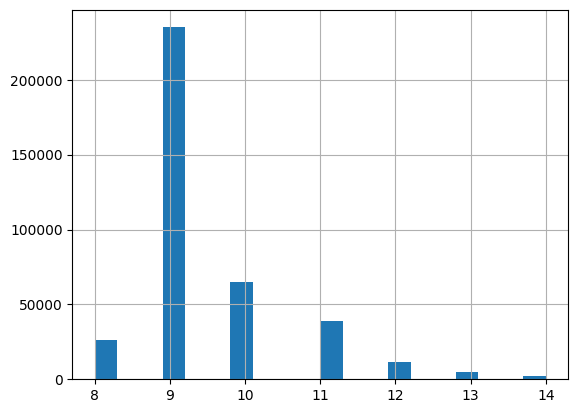

In [7]:
# length distributions of peptides
df['Peptide_Lengths'] = df['Peptide'].apply(len)
df['Peptide_Lengths'].hist(bins=20)

# Build XgBoost model for peptides with length of 9

In [8]:
df_9 = df[df['Peptide_Lengths'] == 9]

#alleles_to_exclude = ['C1505', 'B1401', 'C0704', 'B4801', 'C1602', 'B1803']
#df_9 = df_9[~df_9['Allele'].isin(alleles_to_exclude)]

allele_counts = df_9['Allele'].value_counts()
# Create a mask to filter IDs that appear at least 10 times
mask = df_9['Allele'].map(allele_counts) >= 10
df_9 = df_9[mask]

In [9]:
ninemer_encoder = OneHotEncoder()
X_encoded = np.array([list(s) for s in df_9['Peptide'].values])
X_encoded = ninemer_encoder.fit_transform(X_encoded).toarray()

ninemer_label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = ninemer_label_encoder.fit_transform(df_9['Allele'].values)


In [10]:
X_train_encoded, X_test_encoded, y_train_labeled, y_test_labeled = train_test_split(X_encoded, y_labeled, test_size=0.1, random_state=1)
#X_train_encoded, X_valid_encoded, y_train_labeled, y_valid_encoded = train_test_split(X_train_encoded, y_train_labeled, test_size=0.12, random_state=1) # 0.12 x 0.9 ~ 0.1

In [11]:
# I learned that alpha is important when the data-set size is small; and also early stopping
# could be important. As a result, we must do a hyper-parameter grid search but I don't have enough compute
# power in my laptop so just training k = 9 for now

num_classes = len(np.unique(df_9['Allele']))
model_l9 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    learning_rate=0.2,
    n_estimators=3,
    eval_metric = "mlogloss",
    #alpha = 0.0001,
    booster = "gblinear"
)

# Train the model while monitoring the evaluation metrics
model_l9.fit(
    X_train_encoded, y_train_labeled,
    eval_set=[(X_train_encoded, y_train_labeled), (X_test_encoded, y_test_labeled)],  # Datasets for evaluation
    verbose=True
)


[0]	validation_0-mlogloss:3.34041	validation_1-mlogloss:3.35545
[1]	validation_0-mlogloss:2.84202	validation_1-mlogloss:2.86180
[2]	validation_0-mlogloss:2.60235	validation_1-mlogloss:2.62648


XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=119, num_parallel_tree=None, ...)

In [19]:
def save_model_params(feature_encoder, label_encoder, my_model, file_path):
        joblib.dump(my_model, file_path + "_xgboost_model.joblib")
        joblib.dump(feature_encoder, file_path + '_feature_encoder.joblib')
        joblib.dump(label_encoder, file_path + '_label_encoder.joblib')

def load_model_params(file_path):
        my_model = joblib.load(file_path + "_xgboost_model.json")
        feature_encoder = joblib.load(file_path + '_feature_encoder.joblib')
        label_encoder = joblib.load(file_path + '_label_encoder.joblib')


In [20]:
save_model_params(ninemer_encoder, ninemer_label_encoder, model_l9,
                  "/Users/halasadi/code/pmhc_methods_tf/internal_data/2023_12_22_test_9mer_xgboost_model")

In [11]:
model_params = model_l9.get_params()
print(model_params)

{'objective': 'multi:softmax', 'base_score': None, 'booster': 'gblinear', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 119}


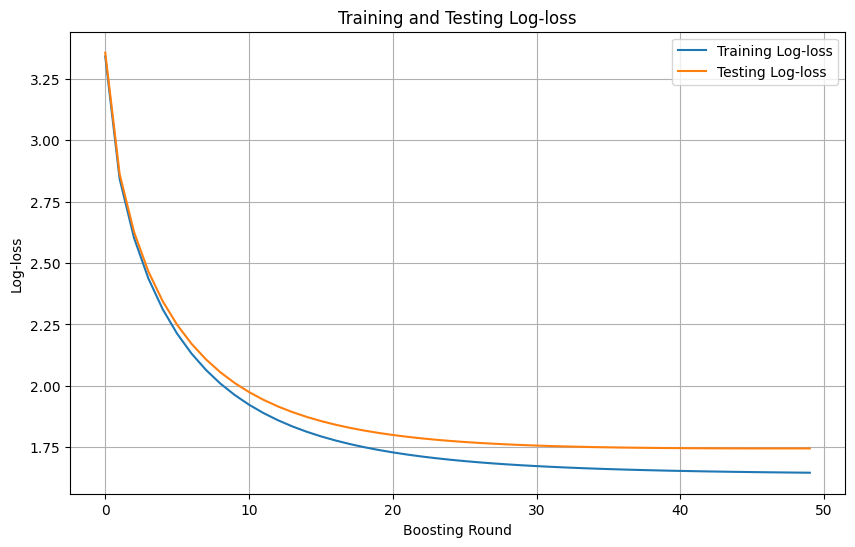

In [13]:
# Get the evaluation results for both training and validation sets
results = model_l9.evals_result()

# Extract log-loss values
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

# Plot log-loss
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label="Training Log-loss")
plt.plot(test_logloss, label="Testing Log-loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log-loss")
plt.title("Training and Testing Log-loss")
plt.legend()
plt.grid(True)
plt.show()

Compare to MixMHCpred

In [14]:

test_peptides = ninemer_encoder.inverse_transform(X_test_encoded)
test_peptides = ["".join(x) for x in test_peptides]
test_peptides_file = "/Users/halasadi/code/pmhc_methods_tf/internal_data/test_peptides.fasta"

# Open the output file for writing
with open(test_peptides_file, "w") as fasta_file:
    for peptide in test_peptides:
        # Write the peptide name as the header line starting with ">"
        fasta_file.write(f">{peptide}\n")
        fasta_file.write(f"{peptide}\n")


true_labels = ninemer_label_encoder.inverse_transform(y_test_labeled)
df_9_test_truth = pd.DataFrame({'Peptide':test_peptides, 'Allele': true_labels})

In [15]:
import subprocess

out_file = '/Users/halasadi/code/pmhc_methods_tf/internal_data/out.txt'
command = ["/Users/halasadi/code/MixMHCpred-master/MixMHCpred", "-i", test_peptides_file, '-o', out_file, '-a', ",".join(np.unique(df_9['Allele'].values))]
try:
    output = subprocess.check_output(command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Command failed with return code {e.returncode}")

In [19]:
y_pred = model_l9.predict(X_test_encoded)
pred_labels = ninemer_label_encoder.inverse_transform(y_pred)
accuracy = accuracy_score(pred_labels, df_9_test_truth['Allele'].values)
print(f"Accuracy of XgBoost: {accuracy}")

pred_p = model_l9.predict_proba(X_test_encoded)
max_p = np.amax(pred_p, axis=1)
accuracy = accuracy_score(pred_labels[max_p > 0.9], df_9_test_truth['Allele'][max_p > 0.9].values)
print(f"Accuracy of High Confidence XgBoost Calls: {accuracy}")

Accuracy of XgBoost: 0.4506508976431549
Accuracy of High Confidence XgBoost Calls: 0.9393939393939394


In [20]:
df_out = pd.read_csv(out_file, sep='\t', comment='#')
mixmhcpredout = df_out[['Peptide', 'BestAllele']]
mixmhcpredout = mixmhcpredout.merge(df_9_test_truth, on = "Peptide", how = "left")
accuracy = accuracy_score(mixmhcpredout['Allele'], mixmhcpredout['BestAllele'])
print(f"Accuracy of MixMHCPred: {accuracy}")

Accuracy of MixMHCPred: 0.3341403483414035


It looks like our XgBoost model beats the PWM approach by a noticeable margin!

save XgBoost model

# Build XgBoost model for peptides with length 10 and investigating whether data from peptide lengths == 9 helps.

Here we will use our XgBoost model trained on 9mers on 10mers 

In [10]:
df_10 = df[df['Peptide_Lengths'] == 10]

In [11]:
#allele_counts = df_10['Allele'].value_counts()
# Create a mask to filter IDs that appear at least 10 times
#mask = df_10['Allele'].map(allele_counts) >= 10
# Apply the mask to filter the DataFrame
#df_10 = df_10[mask]

alleles_to_exclude = ['C1505', 'B1401', 'C0704', 'B4801', 'C1602', 'B1803']
df_10 = df_10[~df_10['Allele'].isin(alleles_to_exclude)]

Let's investigate whether there is signal in the 9mer data that has predictive signal in the 10mer data. 

In [12]:
all_substrings_of_length_9 = [(s[:9], s[1:10]) for s in df_10['Peptide'].values]


sub_peptides_1 = [tu[0] for tu in all_substrings_of_length_9]
x_substr_9_1 = np.array([list(s) for s in sub_peptides_1])
x_substr_9_1 = ninemer_encoder.fit_transform(x_substr_9_1).toarray()

sub_peptides_2 = [tu[1] for tu in all_substrings_of_length_9]
x_substr_9_2 = np.array([list(s) for s in sub_peptides_2])
x_substr_9_2 = ninemer_encoder.fit_transform(x_substr_9_2).toarray()

y_pred_9_1 = ninemer_label_encoder.inverse_transform(model_l9.predict(x_substr_9_1))
y_pred_9_2 = ninemer_label_encoder.inverse_transform(model_l9.predict(x_substr_9_2))

max_p1 = np.amax(model_l9.predict_proba(x_substr_9_1), axis=1)
max_p2 = np.amax(model_l9.predict_proba(x_substr_9_2), axis=1)
y_pred_combined = y_pred_9_1
y_pred_combined[max_p2 > max_p1] = y_pred_9_2[max_p2 > max_p1]


print(accuracy_score(y_pred_9_1, df_10['Allele'].values))
print(accuracy_score(y_pred_9_2, df_10['Allele'].values))
print(accuracy_score(y_pred_combined, df_10['Allele'].values))

0.20290680666964328
0.11958245446567413
0.20290680666964328


Yes! There does seem to be substantial signal that is transferable across 9,10 mers. Interestingly, the left aligned peptides do a lot better, which suggests to me that position matters quite a bit here! 

# How well does the model against other methods on an evaluation data-set

In [46]:

# Read data from Pyke et al
file_path = "/Users/halasadi/code/pmhc_methods_tf/external_data/mixmhcpred/pyke_supplemental_table_s1.xlsx"
df_excel = pd.read_excel(file_path, sheet_name= "Unique Peptides")

In [96]:
# I dont understand, shouldn't this be zero?
len(set(df_excel['peptide']).intersection(df_9['Peptide'].values))

15640

In [53]:
df_excel['peptide_length'] = df_excel['peptide'].apply(len)
df_excel_sub = df_excel[df_excel['peptide_length'] == 9]


In [102]:
# I dont understand, shouldn't this be zero?
len(set(df_excel_sub['peptide']).intersection(df_9['Peptide'].values))
len(df_excel_sub['peptide'])

27418

In [103]:
df_excel_sub = df_excel_sub[~df_excel_sub['peptide'].isin(df_9['Peptide'].values)]

In [105]:
import re

def parse_hla(hla):
    match = re.match(r"HLA-(\w)(\d+):(\d+)", hla)
    hla_parsed = match.group(1) + match.group(2) + match.group(3)
    return(hla_parsed)

In [106]:
df_excel_sub['allele_formatted'] = df_excel_sub['allele'].apply(parse_hla).values

In [107]:
X_encoded_external = np.array([list(s) for s in df_excel_sub['peptide'].values])
X_encoded_external = ninemer_encoder.fit_transform(X_encoded_external).toarray()

In [108]:
y_pred = model_l9.predict(X_encoded_external)
pred_labels = ninemer_label_encoder.inverse_transform(y_pred)
accuracy = accuracy_score(pred_labels, df_excel_sub['allele_formatted'].values)
print(f"Accuracy of XgBoost: {accuracy}")

Accuracy of XgBoost: 0.39241721324588064


# Compare against MixMHCPred

In [109]:
pyke_peptides_file = "/Users/halasadi/code/pmhc_methods_tf/internal_data/test_peptides_pyke.fasta"
# Open the output file for writing
with open(pyke_peptides_file, "w") as fasta_file:
    for peptide in df_excel_sub['peptide'].values:
        # Write the peptide name as the header line starting with ">"
        fasta_file.write(f">{peptide}\n")
        fasta_file.write(f"{peptide}\n")

out_file = '/Users/halasadi/code/pmhc_methods_tf/internal_data/pyke_out.txt'
command = ["/Users/halasadi/code/MixMHCpred-master/MixMHCpred", "-i", pyke_peptides_file, '-o', out_file, '-a', ",".join(np.unique(df_9['Allele'].values))]
try:
    output = subprocess.check_output(command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Command failed with return code {e.returncode}")

In [110]:
df_out = pd.read_csv(out_file, sep='\t', comment='#')
mixmhcpredout = df_out[['Peptide', 'BestAllele']]
mixmhcpredout = mixmhcpredout.rename(columns = {'Peptide': 'peptide'})
mixmhcpredout = mixmhcpredout.merge(df_excel_sub, on = "peptide", how = "left")
accuracy = accuracy_score(mixmhcpredout['allele_formatted'], mixmhcpredout['BestAllele'])
print(f"Accuracy of MixMHCPred: {accuracy}")

Accuracy of MixMHCPred: 0.18327641519196936


In [114]:
import mhcflurry

In [116]:
!mhcflurry-downloads --quiet fetch models_class1_presentation

2023-12-18 13:25:01.668025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
135MB [05:16, 428kB/s]                                                          
Extracting: 100%|███████████████████████████████| 62/62 [00:24<00:00,  2.56it/s]


In [117]:
predictor = mhcflurry.Class1PresentationPredictor.load()

In [119]:
#df_excel_sub['allele_netmhc'] = df_excel_sub['allele'].apply(lambda x: x.replace("HLA-", "A*"))

In [123]:
#alleles = np.unique(df_excel_sub['allele_netmhc'])
#results1 = predictor.predict(df_excel_sub['peptide'].values, alleles)

# Graveyard

Then we will train a new classifier based on 10mer data only

In [22]:
tenmer_encoder = OneHotEncoder()
X_encoded = np.array([list(s) for s in df_10['Peptide'].values])
X_encoded = tenmer_encoder.fit_transform(X_encoded).toarray()

#tenmer_label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = ninemer_label_encoder.fit_transform(df_10['Allele'].values)


In [23]:
X_train_encoded, X_test_encoded, y_train_labeled, y_test_labeled = train_test_split(X_encoded, y_labeled, test_size=0.1, random_state=1)
X_train_encoded, X_valid_encoded, y_train_labeled, y_valid_labeled = train_test_split(X_train_encoded, y_train_labeled, test_size=0.12, random_state=1) # 0.12 x 0.9 ~ 0.1

In [15]:
num_classes = len(np.unique(y_train_labeled))
model_l10 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric = "mlogloss"
)

# Train the model while monitoring the evaluation metrics
model_l10.fit(
    X_train_encoded, y_train_labeled,
    eval_set=[(X_train_encoded, y_train_labeled), (X_valid_encoded, y_valid_labeled)],  # Datasets for evaluation
    verbose=True
)


NameError: name 'y_valid_labeled' is not defined

In [25]:
y_pred = model_l10.predict(X_test_encoded)
pred_labels = ninemer_label_encoder.inverse_transform(y_pred)

test_peptides = tenmer_encoder.inverse_transform(X_test_encoded)
test_peptides = ["".join(x) for x in test_peptides]
true_labels = ninemer_label_encoder.inverse_transform(y_test_labeled)
df_10_test_truth = pd.DataFrame({'Peptide':test_peptides, 'Allele': true_labels})

accuracy = accuracy_score(pred_labels, df_10_test_truth['Allele'].values)
print(f"Accuracy of XgBoost: {accuracy}")

Accuracy of XgBoost: 0.46813423645320196


In [26]:
all_test_substrings_of_length_9 = [(s[:9], s[1:10]) for s in df_10_test_truth['Peptide'].values]
test_sub_peptides_1 = [tu[0] for tu in all_test_substrings_of_length_9]
x_substr_9_1 = np.array([list(s) for s in test_sub_peptides_1])
x_substr_9_1 = ninemer_encoder.fit_transform(x_substr_9_1).toarray()

In [27]:
p10 = model_l10.predict_proba(X_test_encoded)
p9 = model_l9.predict_proba(x_substr_9_1)

In [45]:
# maybe try something like this
ptotal = 0.2 * p9 + 0.8 * p10

In [46]:
max_i = ptotal.argmax(axis = 1)
pred_labels_by_total = ninemer_label_encoder.inverse_transform(max_i)

In [48]:
accuracy = accuracy_score(pred_labels_by_total, df_10_test_truth['Allele'].values)
print(f"Accuracy of Combined Methods, using 9mer and 10mers: {accuracy}")

Accuracy of Combined Methods, using 9mer and 10mers: 0.4676724137931034
